In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.21.0-py3-none-any.whl (4.7 MB)
  Using cached huggingface_hub-0.8.1-py3-none-any.whl (101 kB)
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 132 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=c5e3ad51ef32b1be319143ba567e15a9191521d0e762fbf6612ffbc07729577e
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=54eb94327d69a02def4d15273032aebabe8f4224f35a746646a82d354fb5d065
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=452a90b012e817dc83f18468289cb53ea5cb93036df4fb16b742346f622b1911
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow p

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import pandas as pd

In [6]:
### --------- Mount Drive --------- ###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Import data from csv
df = pd.read_csv('/content/drive/MyDrive/Datasets/hum_crisis_class.tsv', sep='\t', header=0,encoding='latin-1')
df.head()

,id,tweet_text,class_label,event
0,3.480000e+17,"As many as 100,000 people could be forced from...",caution_and_advice,2013_alberta_floods
1,5.920000e+17,RT @artdielle: #PersonFinder site to assist #N...,caution_and_advice,2015_nepal_earthquake
2,4.510000e+17,RT @ABC: UPDATE: USGS upgrades major earthquak...,caution_and_advice,2014_chile_earthquake
3,5.760000e+17,RT @kenringweather: Earthquake risks for North...,caution_and_advice,2015_vanuatu_cyclone
4,3.480000e+17,"SAF cancelled outfield exercises, NEA advised ...",caution_and_advice,2013_singapore_haze


In [8]:
df['class_label_out'] = pd.Categorical(df['class_label'])

# Transform your output to numeric
df['class_label'] = df['class_label_out'].cat.codes

In [9]:
df.dtypes


id                  float64
tweet_text           object
class_label            int8
event                object
class_label_out    category
dtype: object

In [32]:
import re
text_array=[]
for tweet in df['tweet_text']:
  text = re.sub(r'https?://[^ ]+', '', tweet)
  text_array.append(text)

In [33]:
df['new_text']=text_array

In [34]:
text_array=[]
for tweet in df['new_text']:
  text = re.sub(r'@[^ ]+', '', tweet)
  text_array.append(text)
df['new_text']=text_array  

In [35]:
text_array=[]
for tweet in df['new_text']:
  transf = re.sub(r'#', '', tweet)
  text_array.append(transf)
df['new_text']=text_array   

In [36]:
text_array=[]
for tweet in df['new_text']:
  transf = re.sub(r'([A-Za-z])\1{2,}', r'\1', tweet)
  text_array.append(transf)
df['new_text']=text_array 

In [37]:
text_array=[]
for tweet in df['new_text']:
  transf = re.sub(r' 0 ', 'zero', tweet)
  transf = re.sub(r'[^A-Za-z ]', '', transf)
  text_array.append(transf)
df['new_text']=text_array

In [38]:
text_array=[]
for tweet in df['new_text']:
  transf = tweet.lower()
  text_array.append(transf)
df['new_text']=text_array

In [39]:
import spacy
spacy_nlp=spacy.load('en_core_web_sm', disable=['parser', 'ner'])
df["new_text"]=df["new_text"].apply(lambda x: " ".join([token.lemma_ for token in spacy_nlp(x)]))

In [10]:
from transformers import DistilBertTokenizer, RobertaTokenizer ,BertTokenizerFast
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model
#roberta = 'roberta-base-uncase'
#bert='bert-base-uncased'
# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                               max_length=128, pad_to_max_length=True)
#tokenizer = BertTokenizerFast.from_pretrained(bert, do_lower_case=True, add_special_tokens=True,
 #                                              max_length=128, pad_to_max_length=True)

In [11]:
!pip3 install tqdm



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np

In [13]:
from tqdm import tqdm


In [14]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=128, pad_to_max_length=True,  #128
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


In [15]:
from sklearn.model_selection import train_test_split

In [40]:
X = df['tweet_text']
y = df['class_label']
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20,stratify = df['class_label'])

In [41]:
X_train.head()

30370    If someone is at Leogane where should they go ...
57773    #PrayForChile #Chile #earthquake #ChileEarthqu...
90391    Lets pray for them #prayforvisayas #visayasear...
78851    Storm surge damage will not be the big story f...
60534      If you can help a countrymen in need please do!
Name: tweet_text, dtype: object

In [42]:
y_train.head()

30370    5
57773    7
90391    7
78851    2
60534    7
Name: class_label, dtype: int8

In [43]:
input_id,input_mask,input_segment=tokenize(X_train,tokenizer) 

  0%|          | 0/74240 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 74240/74240 [01:10<00:00, 1052.17it/s]


In [44]:
input_id_test,input_mask_test,segment_test=tokenize(X_test,tokenizer) 

  0%|          | 0/18561 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 18561/18561 [00:16<00:00, 1092.36it/s]


In [45]:
input_id

array([[  101,  2065,  2619, ...,     0,     0,     0],
       [  101,  1001, 11839, ...,     0,     0,     0],
       [  101, 11082, 11839, ...,     0,     0,     0],
       ...,
       [  101, 19387,  1030, ...,     0,     0,     0],
       [  101,  2116, 10575, ...,     0,     0,     0],
       [  101, 19387,  1030, ...,     0,     0,     0]], dtype=int32)

In [22]:
from transformers import DistilBertConfig,TFDistilBertModel,BertConfig,TFBertModel

In [23]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [24]:
from keras.regularizers import l2

In [25]:
from tensorflow.keras.initializers import TruncatedNormal

In [46]:
distil_bert = 'distilbert-base-uncased'
#bert='bert-base-uncased'
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
#config = BertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)
#transformer_model = TFBertModel.from_pretrained(bert, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32') #128
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') #128
print(input_ids_in)
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
#print(embedding_layer[:,0,:])
cls_token = embedding_layer[:,0,:]
#print(cls_token)
X = tf.keras.layers.BatchNormalization()(embedding_layer)   
X = tf.keras.layers.Conv1D(2064,24, activation='relu',kernel_regularizer=l2(0.01))(X)
X = tf.keras.layers.Dropout(0.5)(X)  
X = tf.keras.layers.MaxPooling1D(24)(X) 
X = tf.keras.layers.LSTM(1064,return_sequences=True)(X) 
X=  Attention(return_sequences=False)(X)
X = tf.keras.layers.Dense(512, activation='relu', kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(X)
X = tf.keras.layers.Dropout(0.5)(X) 
X = tf.keras.layers.Dense(8, activation='softmax')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

#for layer in model.layers[:3]:
 # layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_token'), name='input_token', description="created by layer 'input_token'")


In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                         

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5
                                                 ,epsilon=1e-08,
decay=0.01,
clipnorm=1.0),
               loss="sparse_categorical_crossentropy",
              metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [49]:
cnn_history=model.fit([input_id, input_mask],
          y_train,
          validation_data=([input_id_test, input_mask_test],y_test),
          batch_size=64,
          epochs=10)

Epoch 1/10
1160/1160 [==============================] - 818s 696ms/step - loss: 8.1793 - accuracy: 0.8281 - val_loss: 6.7561 - val_accuracy: 0.8646
Epoch 2/10
1160/1160 [==============================] - 805s 694ms/step - loss: 6.2454 - accuracy: 0.8626 - val_loss: 5.8776 - val_accuracy: 0.8701
Epoch 3/10
1160/1160 [==============================] - 805s 694ms/step - loss: 5.6195 - accuracy: 0.8681 - val_loss: 5.4367 - val_accuracy: 0.8722
Epoch 4/10
1160/1160 [==============================] - 805s 694ms/step - loss: 5.2600 - accuracy: 0.8726 - val_loss: 5.1481 - val_accuracy: 0.8736
Epoch 5/10
1160/1160 [==============================] - 805s 694ms/step - loss: 5.0127 - accuracy: 0.8741 - val_loss: 4.9442 - val_accuracy: 0.8752
Epoch 6/10
1160/1160 [==============================] - 806s 695ms/step - loss: 4.8275 - accuracy: 0.8767 - val_loss: 4.7852 - val_accuracy: 0.8762
Epoch 7/10
1160/1160 [==============================] - 805s 694ms/step - loss: 4.6835 - accuracy: 0.8776 - val_

In [50]:
loss, accuracy = model.evaluate([input_id_test, input_mask_test],y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

581/581 [==============================] - 68s 116ms/step - loss: 4.3847 - accuracy: 0.8776
Loss: 4.384670257568359
Accuracy: 0.8776466846466064


In [51]:
from matplotlib import pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


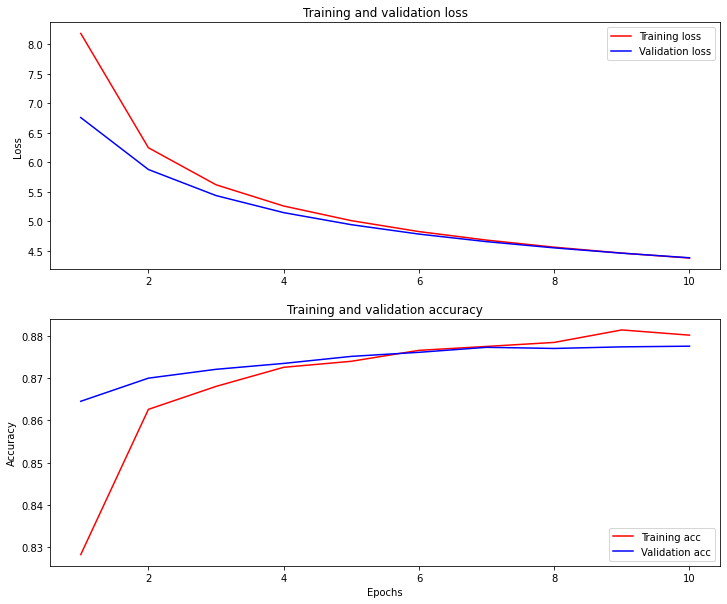

In [52]:
history_dict = cnn_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [53]:
model.save('final_model_events')

INFO:tensorflow:Assets written to: final_model_events/assets


INFO:tensorflow:Assets written to: final_model_events/assets


In [54]:
result =  model.predict([input_id_test, input_mask_test])
print(result.shape)

(18561, 8)


In [55]:
result[0:2]

array([[0.0043904 , 0.00619802, 0.00301764, 0.00726445, 0.00347099,
        0.00577705, 0.94808376, 0.02179783],
       [0.00255277, 0.00110548, 0.00639734, 0.9829221 , 0.00116884,
        0.00191322, 0.00125077, 0.00268949]], dtype=float32)

In [56]:

y_pred = np.argmax(result, axis=-1)

In [57]:
type(y_pred)

numpy.ndarray

In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


array([[1356,   47,  130,   22,    2,   15,   63,   42],
       [  21,  790,    9,   17,    5,    5,   45,   10],
       [  77,   17, 2272,   63,    2,   52,   93,   67],
       [  19,   20,   84, 2443,    7,    8,   87,   49],
       [   2,    3,    9,   30,   93,    5,   27,    9],
       [  33,   12,   18,   16,    6, 1554,  241,   24],
       [  31,   40,   71,   25,    7,  108, 5370,   81],
       [  26,    6,   39,   47,    3,   57,  217, 2412]])

In [59]:
#Generating classification report
import sklearn.metrics as metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1677
           1       0.84      0.88      0.86       902
           2       0.86      0.86      0.86      2643
           3       0.92      0.90      0.91      2717
           4       0.74      0.52      0.61       178
           5       0.86      0.82      0.84      1904
           6       0.87      0.94      0.90      5733
           7       0.90      0.86      0.88      2807

    accuracy                           0.88     18561
   macro avg       0.86      0.82      0.84     18561
weighted avg       0.88      0.88      0.88     18561



In [60]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score


In [61]:
print("ACCURACY:",accuracy_score(y_test,y_pred))
print("PRECISION:",precision_score(y_test,y_pred,average='micro'))
print("RECALL",recall_score(y_test,y_pred,average='micro'))
print("F1 SCORE",f1_score(y_test,y_pred,average='micro'))

ACCURACY: 0.8776466785194763
PRECISION: 0.8776466785194763
RECALL 0.8776466785194763
F1 SCORE 0.8776466785194763
